# Processamento de Linguagem Natural

Professor: Yuri Malheiros

## Long Short-Term Memory (LSTM)

Neste notebook temos a implementação de uma rede LSTM utilizando o Pytorch. Utilizaremos um dataset de review de filmes e treinaremos uma LSTM para classificar o review como positivo ou negativo.

Primeiramente, vamos instalar a biblioteca `datasets`. Através dela carregaremos o dataset de reviews.

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.0 MB/s eta 0:00:00


### Preparando os Dados

Com a instalação concluída, carregamos o dataset.

In [3]:
import datasets

dataset = datasets.load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

O dataset é dividido em três conjuntos: `train`, `test` e `unsupervised`. Cada conjunto possui duas features: `text` que contém o texto do review e `label` que tem o valor 0 se o review for negativo e o valor 1 se ele for positivo.



In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [ ]:
dataset['train']['label'][0]

0

Em seguida, precisamos dividir o texto em tokens. Para isso, utilizaremos o `get_tokenizer` do torchtext.

In [5]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

Tokenizar um string retorna uma lista de tokens:

In [6]:
print(tokenizer(dataset['train']['text'][0]))

['i', 'rented', 'i', 'am', 'curious-yellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', '.', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'u', '.', 's', '.', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', ',', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to', 'see', 'this', 'for', 'myself', '.', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', '.', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam', 'war', 'and', 'race', 'issues', 

Vamos fazer isso para todo o dataset. Para isso, criamos uma função `split_tokens` que aplica o tokenizer às features `text` do dataset. Por fim, usamos a função `map` do dataset para aplicar `split_tokens` a todos os exemplos.

In [7]:
def split_tokens(row):
    row['tokens'] = tokenizer(row['text'])
    return row

In [8]:
dataset = dataset.map(split_tokens)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Percebam que o dataset agora tem três features: `text`, `label` e `tokens`. Esta última foi adicionada após aplicação do `split_tokens`.



In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'tokens'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'tokens'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'tokens'],
        num_rows: 50000
    })
})

In [10]:
print(dataset['train']['tokens'][0])

['i', 'rented', 'i', 'am', 'curious-yellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', '.', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'u', '.', 's', '.', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', ',', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to', 'see', 'this', 'for', 'myself', '.', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', '.', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam', 'war', 'and', 'race', 'issues', 

Após gerar os tokens, precisamos criar o vocabulário. Sabemos que em uma rede neural, os tokens são representados por números, então é necessário fazer esse mapeamento. Utilizando a função abaixo, criamos um vocabulário e teremos o mapeamento token-id. Para simplificar, consideramos apenas os tokens que aparecem pelo menos 3 vezes no dataset. Por fim, acrescentamos um token `<unk>` que representará qualquer token que não fizer parte do vocabulário.


In [11]:
from torchtext.vocab import build_vocab_from_iterator

vocab_custom = build_vocab_from_iterator(dataset['train']['tokens'],
                                         min_freq=3,
                                         specials=['<unk>'])

Para consultar o id tem um token, basta consultar o seu valor como em um dicionário.

In [12]:
vocab_custom['dog']

894

O token `<unk>` tem o id 0

In [13]:
vocab_custom['<unk>']

0

Para definir `<unk>` como o token a ser usado para os tokens fora do vocabulário, vamos defini-lo como default.

In [15]:
vocab_custom.set_default_index(vocab_custom['<unk>'])

Um token inexistente no vocabulário terá sempre valor 0, ou seja, `<unk>`.

In [16]:
vocab_custom['catdog']

0

Usamos a função `len` para saber a quantidade de tokens no vocabulário.

In [17]:
len(vocab_custom)

40251

Para rede neural, não passamos como entrada uma lista de tokens, mas uma lista de ids que correspondem aos tokens. Para isso, primeiramente vamos criar uma função que gera uma lista de ids a partir de uma lista de tokens.

In [18]:
def vocab(tokens):
  result = []
  for token in tokens:
    result.append(vocab_custom[token])

  return result

Exemplo de uso da função `vocab`:

In [19]:
vocab(['the', 'book', 'is', 'on', 'the', 'table'])

[1, 275, 9, 27, 1, 2724]

Para cada exemplo do dataset, vamos criar uma lista de ids de tokens a partir da lista de tokens. Utilizamos uma abordagem similar a que fizemos para gerar a lista de tokens para todo o dataset.

Primeiro criamos uma função que vai aplicar a função `vocab` e em seguida usamos a função `map` para aplicá-la ao dataset completo.

In [20]:
def token2id(row):
    row['tokens_id'] = vocab(row['tokens'])
    return row

In [21]:
dataset = dataset.map(token2id)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Notem que o dataset agora possui quatro features: `text`, `label` e `tokens` e `tokens_id`.

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'tokens', 'tokens_id'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'tokens', 'tokens_id'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'tokens', 'tokens_id'],
        num_rows: 50000
    })
})

In [23]:
print(dataset['train']['tokens_id'][0])

[12, 1567, 12, 245, 35467, 42, 63, 397, 1134, 91, 6, 36, 1, 7125, 14, 3362, 10, 59, 10, 16, 93, 628, 11, 6920, 2, 12, 86, 552, 14, 37, 93, 10, 16, 20192, 39, 1224, 2, 15, 2, 9262, 50, 10, 130, 779, 7, 2479, 13, 681, 3, 1574, 117, 5, 341, 6, 113, 1159, 3051, 12, 71, 74, 7, 73, 13, 18, 536, 2, 1, 120, 9, 5958, 193, 5, 190, 3861, 473, 1423, 765, 4313, 41, 488, 7, 833, 286, 60, 57, 49, 126, 2, 11, 825, 60, 488, 7, 1131, 46, 11858, 7, 256, 55, 440, 6, 668, 27, 53, 1, 862, 29736, 208, 49, 780, 1000, 1303, 146, 17, 1, 2674, 336, 4, 1509, 1303, 11, 1, 2358, 1591, 2, 11, 202, 2181, 7270, 4, 1918, 19585, 6, 21477, 49, 72, 4655, 27, 2380, 3, 60, 51, 401, 19, 46, 473, 1691, 3, 8134, 3, 4, 998, 346, 2, 53, 1079, 77, 49, 12, 245, 35467, 9, 14, 1613, 160, 586, 3, 13, 16, 1159, 8205, 2, 71, 3, 1, 401, 4, 999, 144, 30, 174, 4, 241, 202, 3, 62, 100, 10, 8, 15, 28, 329, 44, 55, 6654, 99, 4460, 2, 142, 63, 23464, 347, 171, 10, 1573, 3, 11, 634, 401, 4, 999, 30, 5, 662, 10197, 11, 3861, 436, 2, 62, 14515, 

### Criando o Dataset e o DataLoader

Como estamos utilizando o Pytorch, vamos criar um Dataset, que é  uma classe que define como o dataset é armazenado e acessado.

In [24]:
from torch.utils.data import Dataset

Para isso criamos uma classe que herda de `Dataset`. Esta classe precisa ter três métodos: `__init__`, `__len__` e `__getitem__`.

`__init__` é o construtor da classe. Nele recebemos os dados e criamos alguns atributos de classe (`self.data` e `self.labels`) que serão acessado nos outros métodos.

`__len__` retorna a quantidade de exemplos do nosso dataset.

`__getitem__` retorna um exemplo de acordo com um índice. Ou seja, ao passar o índice 0 será retornado o primeiro exemplo, passando o índice 1 será retornado o segundo e assim sucessivamente. Um exemplo do nosso dataset é composto da lista de ids de tokens e o seu label correspondente.

In [25]:
import torch

class IMDBDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset['tokens_id']
        self.labels = dataset['label']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

Instanciando o dataset, podemos acessar os seus exemplos.

In [26]:
dataset_imdb = IMDBDataset(dataset['train'])

Notem que o exemplo é composto de duas partes. Um tensor com os ids e um tensor com o valor do label.

In [27]:
dataset_imdb[0]

(tensor([   12,  1567,    12,   245, 35467,    42,    63,   397,  1134,    91,
             6,    36,     1,  7125,    14,  3362,    10,    59,    10,    16,
            93,   628,    11,  6920,     2,    12,    86,   552,    14,    37,
            93,    10,    16, 20192,    39,  1224,     2,    15,     2,  9262,
            50,    10,   130,   779,     7,  2479,    13,   681,     3,  1574,
           117,     5,   341,     6,   113,  1159,  3051,    12,    71,    74,
             7,    73,    13,    18,   536,     2,     1,   120,     9,  5958,
           193,     5,   190,  3861,   473,  1423,   765,  4313,    41,   488,
             7,   833,   286,    60,    57,    49,   126,     2,    11,   825,
            60,   488,     7,  1131,    46, 11858,     7,   256,    55,   440,
             6,   668,    27,    53,     1,   862, 29736,   208,    49,   780,
          1000,  1303,   146,    17,     1,  2674,   336,     4,  1509,  1303,
            11,     1,  2358,  1591,     2,    11,  

Após criar o Dataset, nós passamos ele para instanciar um objeto da classe DataLoader. Este objeto permite iterar e acessar os exemplos do dataset de forma mais simples no Pytorch.

Vamos criar um DataLoader a partir do nosso dataset de treino. Também vamos usar a o parâmetro `shuffle` para o DataLoader misturar o nosso dataset.

In [28]:
from torch.utils.data import DataLoader

dataloader = DataLoader(IMDBDataset(dataset['train']), shuffle=True)

### Criando a Rede Neural

Para criar uma rede neural no Pytorch, criamos uma classe que herda de `nn.Module`. Nossa classe tem dois métodos: `__init__` e `forward`.

Em `__init__` criamos as camadas que fazem parte da rede.

Em `forward` recebemos a entrada e especificamos como ela vai passar pelas camadas até a saída da rede.

A rede possui a seguinte arquitetura:

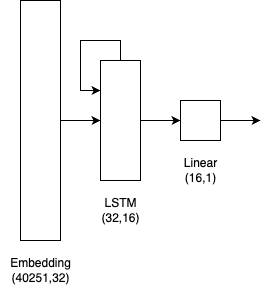

A primeira camada é uma camada de `embedding`. Ela recebe um id de token que é convertido internamente para um one-hot vector. Esse vetor tem tamanho 40251, ou seja, o tamanho do vocabulário. Se for passado o id 42, então o one-hot vector possui valor 1 na posição 42 e 0 em todas as outras posições. Essa camada retorna o embedding de 32 dimensões correspondente ao id passado.

Note que na nossa implementação, a camada de embedding recebe uma lista de ids de tokens. Cada id é convertido para o seu one-hot vector e a camada retorna uma lista de embeddings, um para cada vetor, ou seja, para cada id de token.

Em seguida, cada vetor de embedding é passado um a um para a rede LSTM. Lembre que ao passar o segundo embedding a rede LSTM também usa a saída do passo anterior quando foi passado o primeiro embedding. Essa camada, em cada passo, recebe um vetor de tamanho 32 como entrada e retorna um de tamanho 16 como saída. A camada `lstm` retorna todas as saídas de todos passos (`output`), a última saída (`final_hidden`) e o último estado da célula (`final_cell`).

Para finalizar, a última saída da camada `lstm` é passada para uma camada totalmente conectada (`linear`) que tem como função de ativação a função sigmoid. Essa camada recebe um vetor de tamanho 16 como entrada e retorna um único valor numérico como saída.

In [41]:
from torch import nn

EMBED_LEN = 32
HIDDEN_DIM = 16
N_LAYERS = 1

class TextClassifier(nn.Module):
  def __init__(self):
    super(TextClassifier, self).__init__()

    self.embedding_layer = nn.Embedding(num_embeddings=len(vocab_custom),
                                        embedding_dim=EMBED_LEN)
    self.rnn = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM,
                       num_layers=N_LAYERS)
    self.linear = nn.Linear(HIDDEN_DIM, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    embeddings = self.embedding_layer(input)
    output, (final_hidden, final_cell) = self.rnn(embeddings)
    return self.sigmoid(self.linear(final_hidden[0]))

In [42]:
model = TextClassifier()

In [43]:
model(torch.tensor(dataset['train']['tokens_id'][0]))

tensor([0.5682], grad_fn=<SigmoidBackward0>)

### Treinamento

Para o treinamento, iniciamos passando o modelo para GPU.

In [44]:
device = torch.device('cuda')
model.to(device)

TextClassifier(
  (embedding_layer): Embedding(40251, 32)
  (rnn): LSTM(32, 16)
  (linear): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Utilizaremos uma taxa de aprendizagem de $10^{-3}$, 5 épocas, função de erro entropia cruzada para classificação binária e o otimizador Adam.

In [45]:
LR = 1e-3
EPOCHS = 5
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

A seguir, vamos criar uma função que executa o treinamento.

A função `train` recebe o dataloader para fazer as iterações no loop de treinamento. Para simplificar, nesse exemplo, estamos sempre usando o tamanho do batch igual a 1.

O código abaixo possui comentários para explicar o seu funcionamento de forma detalhada.

In [46]:
from tqdm.notebook import tqdm

def train(dataloader):
  size = len(dataloader.dataset)
  train_loss = 0

  # A cada iteração do for pegaremos uma lista de ids de tokens e o seu label
  # correspondente.
  for batch, (data, label) in enumerate(tqdm(dataloader)):
      # A lista de ids de tokens e o seu label são passados para GPU.
      data, label = data.to(device), label.to(device)

      # A lista de ids de tokens é passada para o modelo. Ele retorna um número
      # entre 0 e 1 (por causa da sigmoid) que é o resultado da classificação.
      out = model(data[0])

      # O erro é calculado. Os valores são convertidos para float por requisito
      # da função de loss.
      loss = loss_fn(out.to(torch.float32), label.to(torch.float32))

      # O erro é acumulado.
      train_loss += loss.item()

      # Backpropagation e atualização dos pesos.
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # A cada 1000 iterações exibir o status do treinamento.
      if batch % 1000 == 0:
          loss, current = loss.item(), batch * len(data)
          print(f' loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

  # Cálculo da média do erro.
  train_loss /= size

  return train_loss

Criaremos a função `test` para testar o modelo nos dados de testes. Essa função é similar a função `train`, mas sem a atualização do modelo.

O código abaixo possui comentários para explicar o seu funcionamento de forma detalhada.

In [47]:
def test(dataloader):
  size = len(dataloader.dataset)
  test_loss = 0
  correct = 0

  # Não vamos atualizar o modelo, por isso, podemos desabilitar o cálculo dos
  # gradientes.
  with torch.no_grad():

    # A cada iteração do for pegaremos uma lista de ids de tokens e o seu label
    # correspondente.
    for data, label in tqdm(dataloader):
      # A lista de ids de tokens e o seu label são passados para GPU.
      data, label = data.to(device), label.to(device)

      # A lista de ids de tokens é passada para o modelo. Ele retorna um número
      # entre 0 e 1 (por causa da sigmoid) que é o resultado da classificação.
      out = model(data[0])

      # O erro é calculado. Os valores são convertidos para float por requisito
      # da função de loss.
      loss = loss_fn(out.to(torch.float32), label.to(torch.float32))

      # O erro é acumulado.
      test_loss += loss.item()

      # O nosso rótulo alvo é binário (0 ou 1), então se a saída for maior que
      # 0.5, consideraremos como 1, caso contrário, consideraremos como 0.
      label_out = 1 if out > 0.5 else 0
      if label_out == label[0]:
        # A contagem de acertos é incrementada.
        correct += 1

  test_loss /= size  # Cálculo da média do erro.
  correct /= size  # Cálculo da acurácia.

  # Exibe o resultado do teste.
  print(f' test accuracy: {(100*correct):>0.1f}%, test loss: {test_loss:>8f} ')

  return test_loss

Instaciamos o DataLoader para os dados de testes.

In [48]:
dataloader_test = DataLoader(IMDBDataset(dataset['test']), shuffle=True)

Para o treinamento, vamos executar um `for` com a quantidade de iterações igual ao número de épocas definido. A cada iteração executamos a função `train` e em seguida a função `test`. Assim saberemos o resultado dos testes a cada época treinada.

Note que os retornos das função `train` e `test` estão sendo guardados em duas listas `train_losses` e `test_losses`. Vamos usar esses resultados para plotar um gráfico a seguir.

In [49]:
train_losses = []
test_losses = []
for t in range(EPOCHS):
    print(f'Epoch {t+1} -------------------------------')

    print('Train')
    train_losses.append(train(dataloader))

    print('Test')
    test_losses.append(test(dataloader_test))

Epoch 1 -------------------------------
Train


  0%|          | 0/25000 [00:00<?, ?it/s]

 loss: 0.573761  [    0/25000]
 loss: 0.908031  [ 1000/25000]
 loss: 0.741581  [ 2000/25000]
 loss: 0.398706  [ 3000/25000]
 loss: 0.362591  [ 4000/25000]
 loss: 1.171235  [ 5000/25000]
 loss: 0.844037  [ 6000/25000]
 loss: 0.785606  [ 7000/25000]
 loss: 0.199912  [ 8000/25000]
 loss: 0.398316  [ 9000/25000]
 loss: 0.622142  [10000/25000]
 loss: 0.165764  [11000/25000]
 loss: 0.346927  [12000/25000]
 loss: 0.552438  [13000/25000]
 loss: 0.129133  [14000/25000]
 loss: 0.174390  [15000/25000]
 loss: 0.825610  [16000/25000]
 loss: 0.403128  [17000/25000]
 loss: 0.098607  [18000/25000]
 loss: 0.198310  [19000/25000]
 loss: 1.579043  [20000/25000]
 loss: 0.195142  [21000/25000]
 loss: 0.222836  [22000/25000]
 loss: 0.341217  [23000/25000]
 loss: 0.117432  [24000/25000]
Test


  0%|          | 0/25000 [00:00<?, ?it/s]

 test accuracy: 81.0%, test loss: 0.426494 
Epoch 2 -------------------------------
Train


  0%|          | 0/25000 [00:00<?, ?it/s]

 loss: 0.673029  [    0/25000]
 loss: 0.066613  [ 1000/25000]
 loss: 1.884157  [ 2000/25000]
 loss: 0.099349  [ 3000/25000]
 loss: 0.103868  [ 4000/25000]
 loss: 0.374567  [ 5000/25000]
 loss: 1.428249  [ 6000/25000]
 loss: 2.937259  [ 7000/25000]
 loss: 2.483718  [ 8000/25000]
 loss: 0.028160  [ 9000/25000]
 loss: 1.181625  [10000/25000]
 loss: 0.152153  [11000/25000]
 loss: 1.217835  [12000/25000]
 loss: 0.032478  [13000/25000]
 loss: 0.257196  [14000/25000]
 loss: 0.585138  [15000/25000]
 loss: 0.027710  [16000/25000]
 loss: 0.053565  [17000/25000]
 loss: 0.049678  [18000/25000]
 loss: 0.052692  [19000/25000]
 loss: 0.224759  [20000/25000]
 loss: 0.027733  [21000/25000]
 loss: 0.025854  [22000/25000]
 loss: 0.049063  [23000/25000]
 loss: 0.296570  [24000/25000]
Test


  0%|          | 0/25000 [00:00<?, ?it/s]

 test accuracy: 81.2%, test loss: 0.467045 
Epoch 3 -------------------------------
Train


  0%|          | 0/25000 [00:00<?, ?it/s]

 loss: 0.130065  [    0/25000]
 loss: 0.147482  [ 1000/25000]
 loss: 0.141916  [ 2000/25000]
 loss: 0.237877  [ 3000/25000]
 loss: 0.062957  [ 4000/25000]
 loss: 0.015508  [ 5000/25000]
 loss: 0.021575  [ 6000/25000]
 loss: 0.031475  [ 7000/25000]
 loss: 0.033953  [ 8000/25000]
 loss: 0.291813  [ 9000/25000]
 loss: 0.076503  [10000/25000]
 loss: 0.046148  [11000/25000]
 loss: 0.004744  [12000/25000]
 loss: 0.038919  [13000/25000]
 loss: 2.481926  [14000/25000]
 loss: 1.256738  [15000/25000]
 loss: 0.012244  [16000/25000]
 loss: 0.012894  [17000/25000]
 loss: 0.015847  [18000/25000]
 loss: 0.073072  [19000/25000]
 loss: 0.010765  [20000/25000]
 loss: 0.001227  [21000/25000]
 loss: 0.072026  [22000/25000]
 loss: 0.078667  [23000/25000]
 loss: 0.012903  [24000/25000]
Test


  0%|          | 0/25000 [00:00<?, ?it/s]

 test accuracy: 88.7%, test loss: 0.279367 
Epoch 4 -------------------------------
Train


  0%|          | 0/25000 [00:00<?, ?it/s]

 loss: 0.030830  [    0/25000]
 loss: 0.001802  [ 1000/25000]
 loss: 0.012053  [ 2000/25000]
 loss: 2.640821  [ 3000/25000]
 loss: 0.009933  [ 4000/25000]
 loss: 0.557531  [ 5000/25000]
 loss: 0.011466  [ 6000/25000]
 loss: 0.022401  [ 7000/25000]
 loss: 0.006962  [ 8000/25000]
 loss: 0.010297  [ 9000/25000]
 loss: 0.005206  [10000/25000]
 loss: 0.011285  [11000/25000]
 loss: 0.004301  [12000/25000]
 loss: 0.003482  [13000/25000]
 loss: 0.005933  [14000/25000]
 loss: 0.041531  [15000/25000]
 loss: 0.976349  [16000/25000]
 loss: 0.006766  [17000/25000]
 loss: 0.000434  [18000/25000]
 loss: 0.103145  [19000/25000]
 loss: 0.123609  [20000/25000]
 loss: 0.019550  [21000/25000]
 loss: 0.041488  [22000/25000]
 loss: 0.727557  [23000/25000]
 loss: 0.147296  [24000/25000]
Test


  0%|          | 0/25000 [00:00<?, ?it/s]

 test accuracy: 89.1%, test loss: 0.300074 
Epoch 5 -------------------------------
Train


  0%|          | 0/25000 [00:00<?, ?it/s]

 loss: 0.341479  [    0/25000]
 loss: 0.004182  [ 1000/25000]
 loss: 0.010114  [ 2000/25000]
 loss: 0.003647  [ 3000/25000]
 loss: 0.652438  [ 4000/25000]
 loss: 0.023574  [ 5000/25000]
 loss: 0.008497  [ 6000/25000]
 loss: 0.002679  [ 7000/25000]
 loss: 0.007265  [ 8000/25000]
 loss: 0.010631  [ 9000/25000]
 loss: 0.003342  [10000/25000]
 loss: 0.012273  [11000/25000]
 loss: 0.003525  [12000/25000]
 loss: 0.001501  [13000/25000]
 loss: 0.003238  [14000/25000]
 loss: 0.007089  [15000/25000]
 loss: 0.025634  [16000/25000]
 loss: 0.013259  [17000/25000]
 loss: 0.002476  [18000/25000]
 loss: 0.017587  [19000/25000]
 loss: 0.020319  [20000/25000]
 loss: 0.005055  [21000/25000]
 loss: 0.088323  [22000/25000]
 loss: 0.003951  [23000/25000]
 loss: 0.017194  [24000/25000]
Test


  0%|          | 0/25000 [00:00<?, ?it/s]

 test accuracy: 88.4%, test loss: 0.314075 


Por fim, vamos traçar as curvas dos erros do treinamento e dos erros do teste.

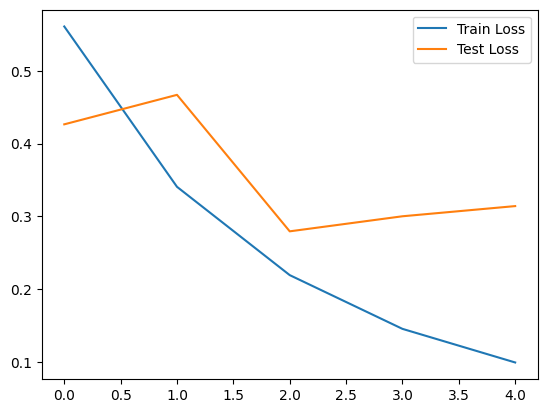

In [50]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()